# Indian Liver Patient Records

Use supervised learning on the Indian patient records to determine which patients have liver disease. The data is from Lichman, M. (2013). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science. There are a number of machine learning papers that work on this data set;for example:
- Bendi Venkata Ramana, Prof. M. S. Prasad Babu and Prof. N. B. Venkateswarlu, "A Critical Comparative Study of Liver Patients from USA and INDIA: An Exploratory Analysis", International Journal of Computer Science Issues, (May 2012)
- Bendi Venkata Ramana and Prof. M.Surendra Prasad Babu, "Liver Classification Using Modified Rotation Forest" International Journal of Engineering Research and Development,  (June 2012)

These works achieve about 73% accuracy using modified rotation forest algorithm. Similar accuracy is obtained amont Kaggle participants. 


I am interested in this dataset because my father has Hepatitis B. Around twnety years ago, he had a routine physical exam and found that his aspartate aminotransferase(AST) and alanine aminotransferase (ALT) levels were high. He was lucky that disease was diagnosed very early. 

## Outline <a id='outline'></a>
I will apply KNN (k-nearest neighbors) algorithm to identify if the patient has liver disease. This is the procedure:
1. [Exploring data](#Exploringdata): 
     - Find missing data, and turn string data into number
     - Inspect the number of patients with and without liver disease among [age and gender groups](#genderage)
     - Find [correlation](#correlation) between columns to see if we can drop some columns 
2. Build [KNN model and hyperparameter tuning](#knn) using five variables: Alamine_Aminotransferase	(ALT) Aspartate_Aminotransferase (AST), Alkaline_Phosphotase (ALP), Albumin, Total_Bilirubin
3. [Compare model performance for male and female patients](#gender) 
4. Build a [model](#threeparams) using three variables:  Alamine_Aminotransferase	(ALT) Aspartate_Aminotransferase (AST), Total_Bilirubin and compare the performance
5. [Future work](#future)


In [1]:
#import packages
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

## Exploring data <a id='Exploringdata'></a>

In [2]:
data = pd.read_csv('indian_liver_patient.csv')
data.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


In [3]:
#observe data types and count the missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
Age                           583 non-null int64
Gender                        583 non-null object
Total_Bilirubin               583 non-null float64
Direct_Bilirubin              583 non-null float64
Alkaline_Phosphotase          583 non-null int64
Alamine_Aminotransferase      583 non-null int64
Aspartate_Aminotransferase    583 non-null int64
Total_Protiens                583 non-null float64
Albumin                       583 non-null float64
Albumin_and_Globulin_Ratio    579 non-null float64
Dataset                       583 non-null int64
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB


In [4]:
#look for the mean and std
data.describe()

,Age,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
count,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,579.000000,583.000000
mean,44.746141,3.298799,1.486106,290.576329,80.713551,109.910806,6.483190,3.141852,0.947064,1.286449
std,16.189833,6.209522,2.808498,242.937989,182.620356,288.918529,1.085451,0.795519,0.319592,0.452490
min,4.000000,0.400000,0.100000,63.000000,10.000000,10.000000,2.700000,0.900000,0.300000,1.000000
25%,33.000000,0.800000,0.200000,175.500000,23.000000,25.000000,5.800000,2.600000,0.700000,1.000000
50%,45.000000,1.000000,0.300000,208.000000,35.000000,42.000000,6.600000,3.100000,0.930000,1.000000
75%,58.000000,2.600000,1.300000,298.000000,60.500000,87.000000,7.200000,3.800000,1.100000,2.000000
max,90.000000,75.000000,19.700000,2110.000000,2000.000000,4929.000000,9.600000,5.500000,2.800000,2.000000


Observations:
1. The gender column is a string. We have to encode the Gender columns. I will encode on a copy of this data set. Two types of encoding methods give similar results, so I am going to show one here. 
2. Albumin_and_Globulin_Ratio conlum has 4 missing values. 
3. Dataset (target) has 1 and 2, which 2 means healthy. 

In [5]:
#Encoding gender columns and save it as data_enz
data_en=data.copy()
data_en['Gender']=data_en['Gender'].astype('category')
data_en['Gender']=data_en['Gender'].cat.codes

# change the target values to to 0 and 1 (1 means sick)
#data_en['Dataset'].replace(2,0,inplace=True)

#Replace encoding of tthe dataset columns in the rawdata for easy visualiation 
data['Dataset'].replace(2,'Healthy',inplace=True)
data['Dataset'].replace(1,'Sick',inplace=True)

### Explore age and gender of the patients<a id='genderage'></a>

Number of patients diagnosed with liver disease:  416
Number of patients not diagnosed with liver disease:  167
Number of patients that are female:  167
Number of patients that are male :  416


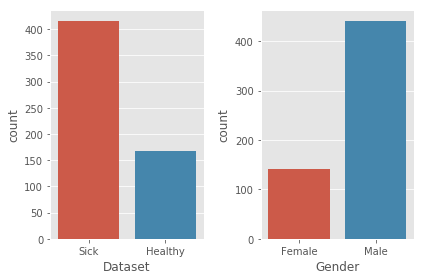

In [6]:
#Counting the number of patients
plt.subplot(1, 2, 1)
sns.countplot(data=data, x = 'Dataset', label='Count')
LD, NLD = data['Dataset'].value_counts()
print('Number of patients diagnosed with liver disease: ',LD)
print('Number of patients not diagnosed with liver disease: ',NLD)

plt.subplot(1, 2, 2)
sns.countplot(data=data, x = 'Gender', label='Count')
M, FM = data['Dataset'].value_counts()
print('Number of patients that are female: ',FM)
print('Number of patients that are male : ',M)
plt.tight_layout()
plt.show()

                Age
Dataset Gender     
Healthy Female   50
        Male    117
Sick    Female   92
        Male    324


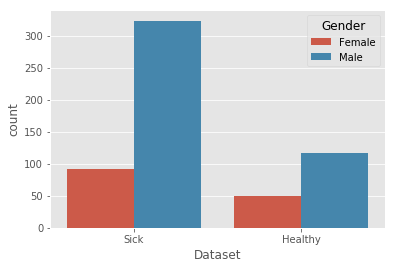

In [7]:
#how many patients with liver disease are female and male?
sns.countplot(data=data, x = 'Dataset', hue='Gender')
sick_gender = data[['Dataset','Gender','Age']].groupby(['Dataset','Gender']).count()
print(sick_gender)

C:\Users\COM\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


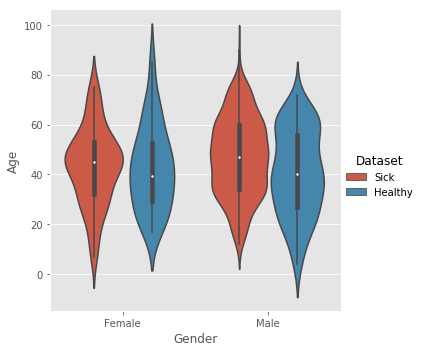

In [8]:
sns.catplot(x='Gender',y='Age',hue='Dataset',kind='violin',data=data)


There are more male patient records than female patients. The age distribution is similar for both gender. Some patients are as young as 4-year-old. It is unclear if the biochemistry of young people is the same as older patients. 

[To outline](#outline)

### Explore correlation between variables<a id='correlation'></a>

Let's plot the data in a scatter matrix, to see whether there's any correlation between variable pairs. We apply the same algorithm for all gender and age; therefore we are dropping these columns for the scatter matrix.

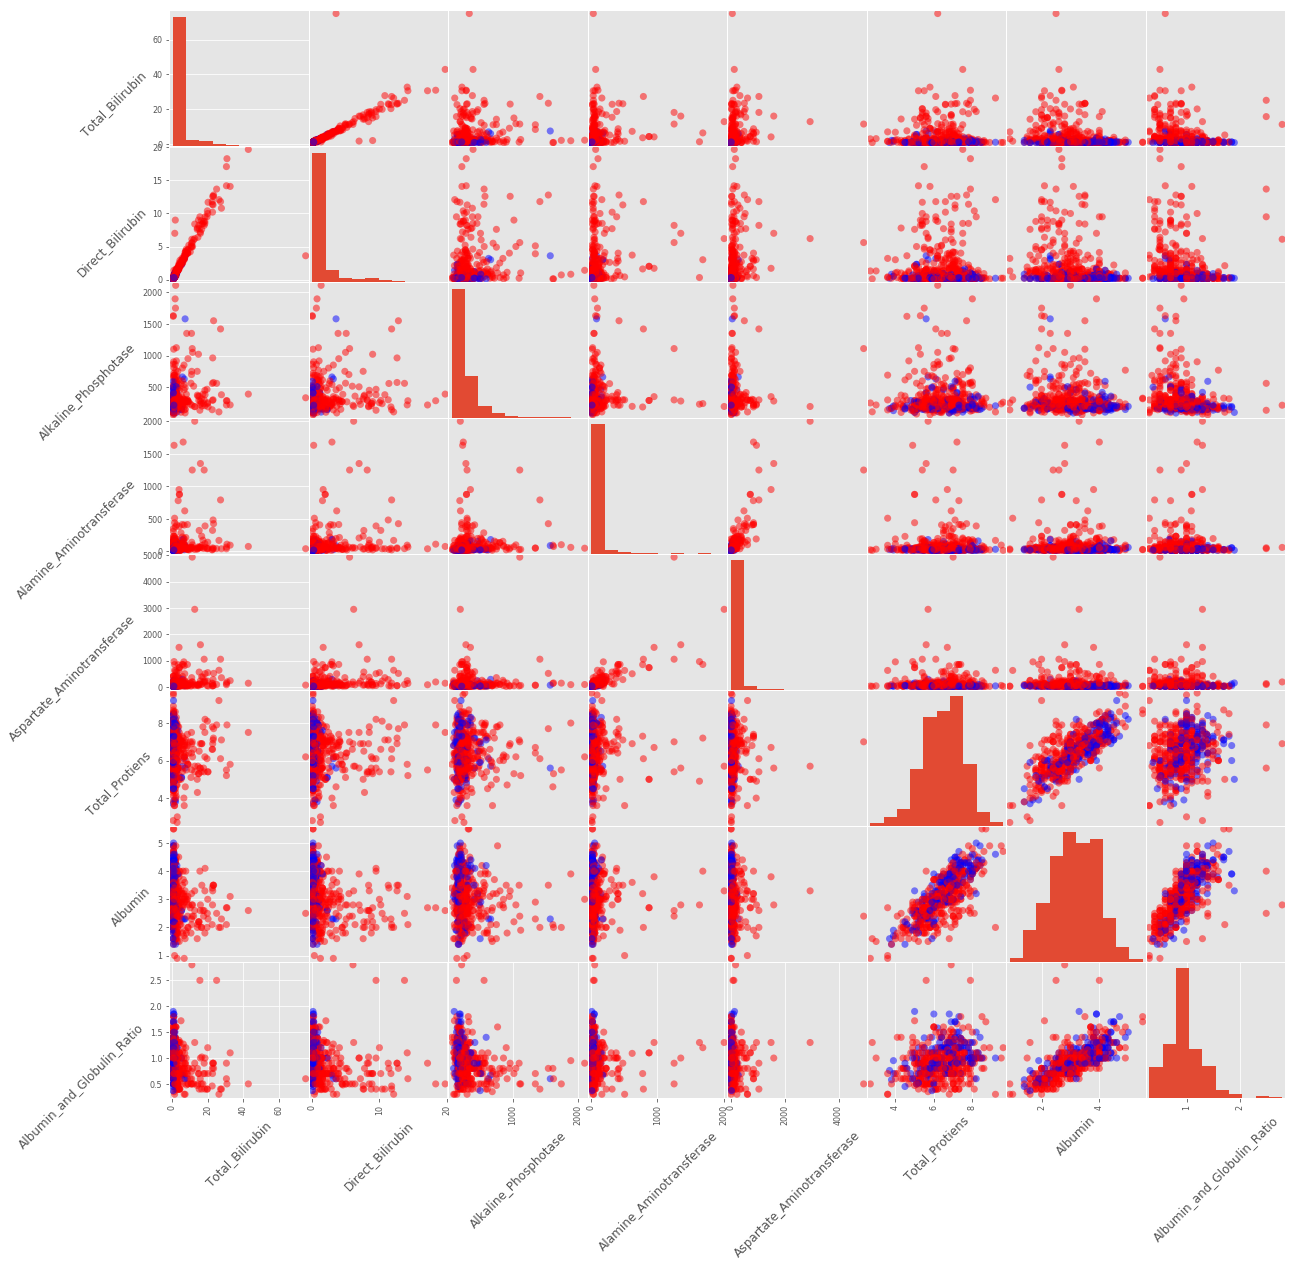

In [9]:
# Scatter matrix plot. Red for sick patients and blue for healthy patients
data_plot=data.drop(['Gender','Age'],axis=1)
color_list=[]
for i in data.dropna()['Dataset'].values:
    if i=='Sick':
        color='red'
    else:
        color='blue'
    color_list.append(color)
sm=pd.plotting.scatter_matrix(data_plot.loc[:,data_plot.columns !='Dataset'].dropna(), figsize=[20,20], c=color_list,s=200,marker='.')
[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.yaxis.label.set_horizontalalignment('right') for s in sm.reshape(-1)]
plt.show()

Sick and healthy patients are not obviously separated into two clusters.  It may be difficult to separate sick and healthy patients. There seems to be four correlation between some variable pairs. Let's explore that using a heatmap of correlation coefficients.

Text(0.5,1,'Correlation between features')

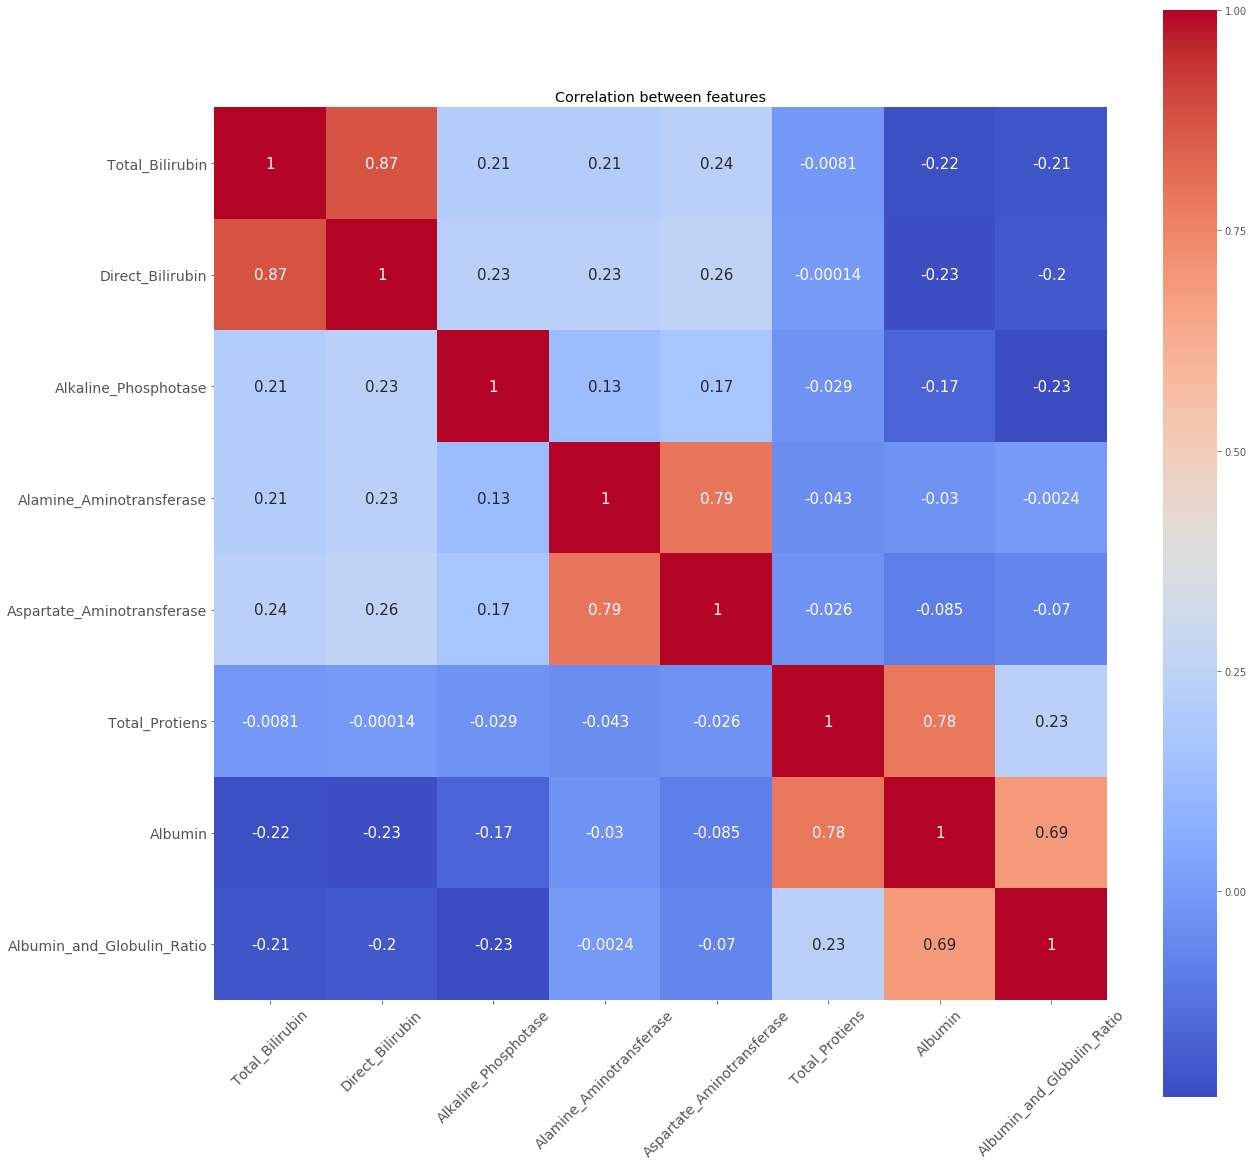

In [10]:
# Correlation between features
liver_corr = data_plot.corr()
plt.figure(figsize=(20, 20))
sn=sns.heatmap(liver_corr, cbar = True,  square = True, annot=True,annot_kws={'size': 15},
           cmap= 'coolwarm')
plt.yticks(rotation=0,fontsize=14) 
plt.xticks(rotation=45,fontsize=14) 
plt.title('Correlation between features')

C:\Users\COM\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


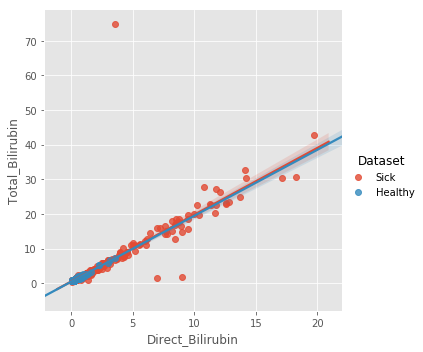

In [11]:
sns.lmplot('Direct_Bilirubin','Total_Bilirubin',data=data,hue='Dataset')

C:\Users\COM\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


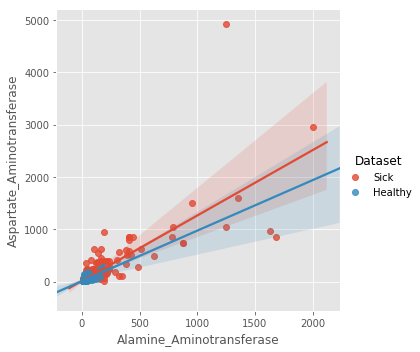

In [12]:
sns.lmplot('Alamine_Aminotransferase','Aspartate_Aminotransferase',data=data,hue='Dataset')

C:\Users\COM\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


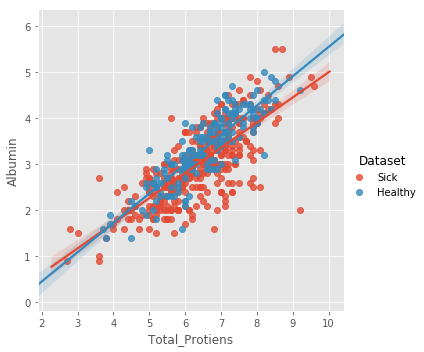

In [13]:
sns.lmplot('Total_Protiens','Albumin',data=data,hue='Dataset')

C:\Users\COM\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


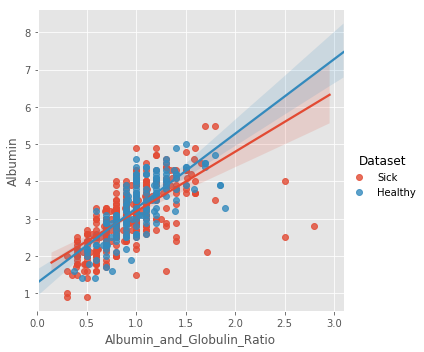

In [14]:
sns.lmplot('Albumin_and_Globulin_Ratio','Albumin',data=data,hue='Dataset')

#### Observations
1. There seems to be relationships between
    - Direct_Bilirubin and Total_Bilirubin
    - Alamine_Aminotransferase (ALT) and Aspartate_Aminotransferase (AST) (but not linear relationship)
    - Albumin and Total_Proteins
    - Albumin and Albumin_and_Globulin_Ratio


2. Good separate between the sick and health patient clusters based on Bilirubin and ALT. If the algorithm can implement ranking, these two varibles should have higher rank.

3. We can drop some of these variables. From googling, I learn that doctors usually use five feature to spot liver problem (alanine transaminase (ALT), aspartate aminotransferase (AST), alkaline phosphatase (ALP), albumin and bilirubin). There is no ALT in the data, but there is Alamine_Aminotransferase column. I assumed that this is a typo. Therefore, I am going to keep the following columns:

    - Alamine_Aminotransferase	(ALT)
    - Aspartate_Aminotransferase (AST)
    - Alkaline_Phosphotase (ALP)
    - Albumin 
    - Total_Bilirubin

Note that although there seems to be correlation between ALT and AST, they don't have a linear relationshop. I tested by dropping one of them in the model and obtained worse result. Therefore, I am going to keep both ALT and AST. 

[To outline](#outline)

## Using K-Nearest Neighbors (KNN)<a id='knn'></a>

Let's use the K-Nearest Neighbors (KNN) classification algorithm, which is a simple supervised learning algorithm. KNN classifies new cases based on a similarity measure to existing data points. Using hyperparameter tuning, we'll determine the number of nearest neighbors to use to obtain the best accuracy.

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [16]:
# I also played around with the alternative for example using Direct_Bilirubin instead of Total_Bilirubin. Total_Bilirubin is better.
predictors = data_en.loc[:,['Alamine_Aminotransferase','Aspartate_Aminotransferase','Alkaline_Phosphotase','Albumin','Total_Bilirubin']].values
print(predictors[:5])

#assign the predictors and target variables 

target=data_en['Dataset'].values
print(np.min(target),np.max(target))

[[ 16.   18.  187.    3.3   0.7]
 [ 64.  100.  699.    3.2  10.9]
 [ 60.   68.  490.    3.3   7.3]
 [ 14.   20.  182.    3.4   1. ]
 [ 27.   59.  195.    2.4   3.9]]
1 2


In [17]:
x_train,x_test,y_train,y_test = train_test_split(predictors,target,test_size = 0.3,random_state = 1)


In [18]:
knn = KNeighborsClassifier(n_neighbors = 23)

In [19]:
#fit to the unscaled data
knn.fit(x_train,y_train)
pred=knn.predict(x_test)
print('With KNN (K=23) and unscaled data the accuracy is',knn.score(x_test,y_test)*100)

With KNN (K=23) and unscaled data the accuracy is 74.85714285714286


In [20]:
#hyper parameters tuning 
neig = np.arange(1, 25)
train_accuracy = []
test_accuracy = []

for i, k in enumerate(neig):
    # k from 1 to 25(exclude)
    knn = KNeighborsClassifier(n_neighbors=k)
    # Fit with knn
    knn.fit(x_train,y_train)
    #train accuracy
    train_accuracy.append(knn.score(x_train, y_train))
    # test accuracy
    test_accuracy.append(knn.score(x_test, y_test))

print("Best accuracy is {} with K = {}".format(np.max(test_accuracy),1+test_accuracy.index(np.max(test_accuracy))))

Best accuracy is 0.7485714285714286 with K = 23


### Score report

KNN Training Score: 
 70.83333333333334
KNN Test Score: 
 73.14285714285714
Accuracy: 
 74.85714285714286
Confusion Matrix: 
 [[113  12]
 [ 32  18]]
Classification Report: 
              precision    recall  f1-score   support

          1       0.78      0.90      0.84       125
          2       0.60      0.36      0.45        50

avg / total       0.73      0.75      0.73       175



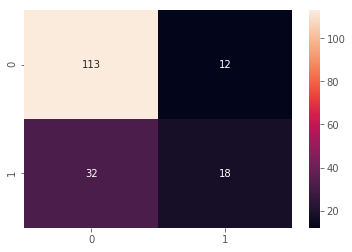

In [21]:
#  1 means sick and 0 means healthy
print('KNN Training Score: \n', knn.score(x_train,y_train)*100)
print('KNN Test Score: \n', knn.score(x_test,y_test)*100)
print('Accuracy: \n', accuracy_score(y_test,pred)*100)
print('Confusion Matrix: \n', confusion_matrix(y_test,pred))
print('Classification Report: \n', classification_report(y_test,pred))

sns.heatmap(confusion_matrix(y_test,pred),annot=True,fmt="d")

## KNN Result Summary

Use KNN classifier to identify patients with liver decease using their blood test data. I obtain 74% accuracy on average with 23 neighbors. The  relavant columns are 'Albumin', 'Alamine_Aminotransferase', 'Aspartate_Aminotransferase', 'Alkaline_Phosphotase','Total_Bilirubin' and we can drop the rest of the variables. 

Other questions we can ask:
- Is the model gender dependent?  Female patients are often misdiagnosed. What's the breakdown in % Females with liver disease versus % males with liver disease?
- Will using less or more features help ?

[To outline](#outline)

We can address the first point by predicting on the data set with has only male and female patients.

### Is the model accuracy gender dependent?<a id='gender'></a>

In [22]:
data_select=data.loc[:,['Gender','Alamine_Aminotransferase','Aspartate_Aminotransferase','Alkaline_Phosphotase','Albumin','Total_Bilirubin','Dataset']]
data_select['Dataset'].replace('Healthy',2,inplace=True)
data_select['Dataset'].replace('Sick',1,inplace=True)
data_select.tail()

,Gender,Alamine_Aminotransferase,Aspartate_Aminotransferase,Alkaline_Phosphotase,Albumin,Total_Bilirubin,Dataset
578,Male,20,34,500,1.6,0.5,2
579,Male,35,31,98,3.2,0.6,1
580,Male,48,49,245,3.2,0.8,1
581,Male,29,32,184,3.4,1.3,1
582,Male,21,24,216,4.4,1.0,2


In [23]:
data_female=data_select[data_select.Gender == 'Female']
data_male=data_select[data_select.Gender=='Male']
data_female.head()

,Gender,Alamine_Aminotransferase,Aspartate_Aminotransferase,Alkaline_Phosphotase,Albumin,Total_Bilirubin,Dataset
0,Female,16,18,187,3.3,0.7,1
6,Female,16,12,154,3.5,0.9,1
7,Female,14,11,202,3.6,0.9,1
13,Female,22,30,214,4.1,1.1,1
18,Female,232,245,293,3.1,0.9,1


In [24]:
x_female = data_female.drop(['Gender','Dataset'],axis=1).values
y_female = data_female['Dataset'].values

In [25]:
x_male = data_male.drop(['Gender','Dataset'],axis=1).values
y_male = data_male['Dataset'].values

Accuracy for female: 
 65.49295774647888
Classification Report for female: 
              precision    recall  f1-score   support

          1       0.69      0.84      0.76        92
          2       0.52      0.32      0.40        50

avg / total       0.63      0.65      0.63       142



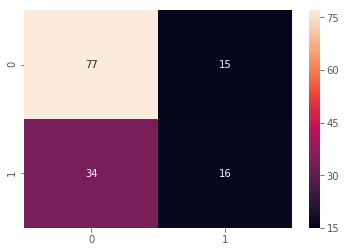

In [26]:
y_pred_female=knn.predict(x_female)
print('Accuracy for female: \n', accuracy_score(y_female,y_pred_female)*100)
print('Classification Report for female: \n', classification_report(y_female,y_pred_female))

sns.heatmap(confusion_matrix(y_female,y_pred_female),annot=True,fmt="d")

Accuracy for male: 
 73.46938775510205
Classification Report for male: 
              precision    recall  f1-score   support

          1       0.76      0.94      0.84       324
          2       0.50      0.18      0.26       117

avg / total       0.69      0.73      0.69       441



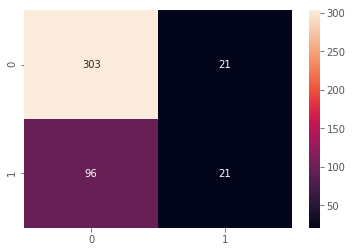

In [27]:
y_pred_male=knn.predict(x_male)
print('Accuracy for male: \n', accuracy_score(y_male,y_pred_male)*100)
print('Classification Report for male: \n', classification_report(y_male,y_pred_male))
sns.heatmap(confusion_matrix(y_male,y_pred_male),annot=True,fmt="d")

The model is better at diagnosing male patients, with an accuracy of 74.6%, compared to an accuracy of 62.0% for female patients.  It's possible this is because there is a lot more data for male patients

### Model performance using only ALT,  AST and Total_Bilirubin <a id='threeparams'></a>

From the correlation plots, clusters of sick and healthy patients have less overlap in the ALT vs AST and and Total_Bilirubin Total_Bilirubin variables. What if only use these variable for our models. 

In [28]:
# already have the target varible defined
predictors2 = data.loc[:,['Alamine_Aminotransferase','Aspartate_Aminotransferase','Total_Bilirubin']].values
x_train,x_test,y_train,y_test = train_test_split(predictors2,target,test_size = 0.3,random_state = 1)


In [29]:
#hyper parameters tuning 
neig = np.arange(1, 25)
train_accuracy = []
test_accuracy = []

for i, k in enumerate(neig):
    # k from 1 to 25(exclude)
    knn = KNeighborsClassifier(n_neighbors=k)
    # Fit with knn
    knn.fit(x_train,y_train)
    #train accuracy
    train_accuracy.append(knn.score(x_train, y_train))
    # test accuracy
    test_accuracy.append(knn.score(x_test, y_test))

print("Best accuracy is {} with K = {}".format(np.max(test_accuracy),1+test_accuracy.index(np.max(test_accuracy))))

Best accuracy is 0.7314285714285714 with K = 12


Using just three parameters ALT vs AST and and Total_Bilirubin to build a model give 73% accuracy similar to those using five parameters. 

## Future work<a id='future'></a>

A number of things we can try in the future. 
1. Apply other models such as XGBoost. 
2. Apply ranking to each parameter as done in the paper by Ramana *et. al.*, 2012 paper. 
3. Apply this model to patients from different countries to see if the model is generalizable. 

[To outline](#outline)
